In [77]:
#Standard
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

#AIF360 Dataset Classes 
from aif360.datasets import StandardDataset
from aif360.datasets import BinaryLabelDataset

#AIF360 Metrics Classes  
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.algorithms.preprocessing import Reweighing
from aif360.metrics import ClassificationMetric

#AIF360 Algorithms 
from aif360.algorithms.preprocessing import Reweighing
from aif360.algorithms.inprocessing import AdversarialDebiasing, PrejudiceRemover
from aif360.algorithms.postprocessing import CalibratedEqOddsPostprocessing, EqOddsPostprocessing
# AI360 Explainers
from aif360.explainers import MetricTextExplainer

#Sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score


#Tensorflow -- install version before 2.0
import tensorflow as tf 

#For Markdown
from IPython.display import Markdown, display

#Helper Functions
from src.classifier_functions import *
from src.dataset_functions import *
from src.fair_classifier_functions import *


### Creating the Datasets to Analyze with AIF 360

In [78]:
data = create_multiple_datasets(create_binary_dataset_salary, [150000, 200000])

In [79]:
train, val, test = create_split_lists(data)

In [80]:
train_mean, train_di = get_dataset_metrics_list(train)

In [81]:
val_mean, val_di = get_dataset_metrics_list(val)

In [82]:
## Getting the Initial Metrics between the Training Set and the Validation Set

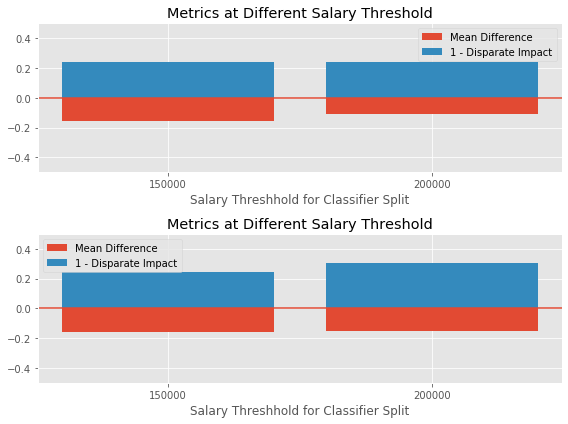

In [83]:
plot_mean_diff_and_di(train_mean, train_di, val_mean, val_di, 'images/initial_metrics.png')

## Creating Predictions from a Random Forest Classifier 

In [84]:
#Excluding Sex as a category on 150,000 Salary Threshold
train_no_gender = train[0].convert_to_dataframe()[0].drop(labels='sex', axis=1)
val_no_gender = val[0].convert_to_dataframe()[0].drop(labels='sex', axis=1)

rf_no_gender = RandomForestClassifier(n_estimators=500, max_depth=5)



In [85]:
X_train = train_no_gender.values[:,0:-1]
y_train = train_no_gender.values[:,-1]
X_test = val_no_gender.values[:,0:-1]
y_test = val_no_gender.values[:,-1]

In [86]:
rf_no_gender.fit(X_train, y_train)
no_gender_preds = rf_no_gender.predict(X_test)

scorecard(y_test, no_gender_preds)

The Accuracy score is 0.774.

The Precision score is 0.729.

The Recall score is 0.997.

      Confusion Matrix


,Actual True,Actual False
Predicted True,964,358
Predicted False,3,275


In [87]:
add_gender = val[0].copy()
add_gender.labels = no_gender_preds

In [88]:
get_dataset_metrics_list([add_gender])

([-0.1941074406389458], [0.2164308593323624])

In [89]:
get_dataset_metrics_list([val[0]])

([-0.16134661994747468], [0.24333460608374702])

In [90]:
## Including Sex as a category
pred_list = get_predictions(RandomForestClassifier(n_estimators=500, max_depth=5), 
                train, val)

In [91]:
pred_mean, pred_di = get_dataset_metrics_list(pred_list)

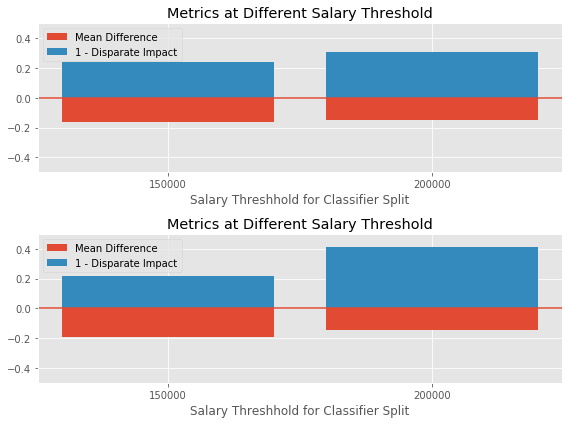

In [92]:
plot_mean_diff_and_di(val_mean, val_di, pred_mean, pred_di, 'images/initial_rf_metrics.png')

## Reweighing to Reduce Bias

In [93]:
privileged_groups= [{'sex':1}]
unprivileged_groups= [{'sex': 0}]
RW = Reweighing(unprivileged_groups=unprivileged_groups, 
               privileged_groups=privileged_groups)

rw_train_datasets = []
for dataset in train: 
    rw = RW.fit_transform(dataset)
    rw_train_datasets.append(rw)
    
# rw_val_datasets = [] 
# for dataset in val: 
#     rw = RW.fit_transform(dataset)
#     rw_val_datasets.append(rw)

In [94]:
rw_train_mean, rw_train_di = get_dataset_metrics_list(rw_train_datasets)
#rw_val_mean, rw_val_di = get_dataset_metrics_list(rw_val_datasets)


In [95]:
#plot_mean_diff_and_di(rw_train_mean, rw_train_di, rw_val_mean, rw_val_di, 'images/rw_metrics.png')

### New Predictions with Reweighted Random Forest

In [96]:
rw_pred_list = get_rw_predictions(RandomForestClassifier(n_estimators=500, max_depth=5), rw_train_datasets, val)

In [97]:
rw_pred_mean, rw_pred_di = get_dataset_metrics_list(rw_pred_list)

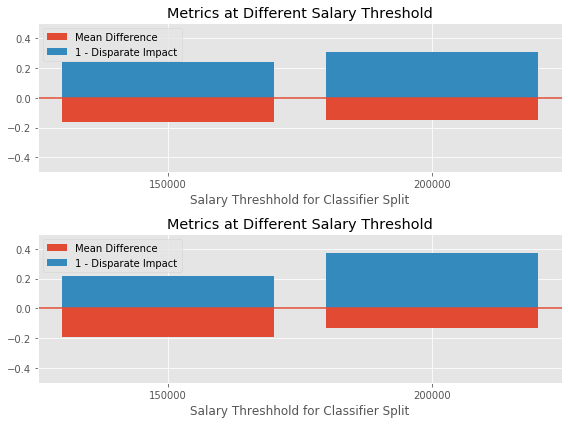

In [98]:
plot_mean_diff_and_di(val_mean, val_di, rw_pred_mean, rw_pred_di, 'images/rw_rf_metrics.png')

### Inprocessing with Adversarial Debiasing 

In [99]:
#sess.close()
tf.reset_default_graph()
sess = tf.Session()

In [100]:
##Creating Tensorflow Session - must not use Tensorflow 2.0 
sess = tf.Session()
db_model = AdversarialDebiasing(privileged_groups = privileged_groups,
                          unprivileged_groups = unprivileged_groups,
                          scope_name='debiased_classifier',
                            num_epochs  = 100,
                            batch_size = 50,
                            adversary_loss_weight = .1,     
                            debias=True,
                          sess=sess)

In [101]:
db_model.fit(train[0]) 

epoch 0; iter: 0; batch classifier loss: 0.994691; batch adversarial loss: 0.827972
epoch 1; iter: 0; batch classifier loss: 0.584147; batch adversarial loss: 0.775386
epoch 2; iter: 0; batch classifier loss: 0.497142; batch adversarial loss: 0.726672
epoch 3; iter: 0; batch classifier loss: 0.472537; batch adversarial loss: 0.772537
epoch 4; iter: 0; batch classifier loss: 0.490176; batch adversarial loss: 0.622168
epoch 5; iter: 0; batch classifier loss: 0.420835; batch adversarial loss: 0.649234
epoch 6; iter: 0; batch classifier loss: 0.445630; batch adversarial loss: 0.619385
epoch 7; iter: 0; batch classifier loss: 0.473040; batch adversarial loss: 0.746078
epoch 8; iter: 0; batch classifier loss: 0.339591; batch adversarial loss: 0.690813
epoch 9; iter: 0; batch classifier loss: 0.503995; batch adversarial loss: 0.705194
epoch 10; iter: 0; batch classifier loss: 0.672144; batch adversarial loss: 0.665241
epoch 11; iter: 0; batch classifier loss: 0.752484; batch adversarial loss:

In [102]:
adb_preds_1 = db_model.predict(val[0])

In [103]:
sess.close()
tf.reset_default_graph()
sess = tf.Session()
db_model = AdversarialDebiasing(privileged_groups = privileged_groups,
                          unprivileged_groups = unprivileged_groups,
                          scope_name='debiased_classifier',
                            num_epochs  = 100,
                            batch_size = 50,
                            adversary_loss_weight = .1,     
                            debias=True,
                          sess=sess)

db_model.fit(train[1]) 

epoch 0; iter: 0; batch classifier loss: 0.689043; batch adversarial loss: 0.741718
epoch 1; iter: 0; batch classifier loss: 0.648484; batch adversarial loss: 0.727423
epoch 2; iter: 0; batch classifier loss: 0.493406; batch adversarial loss: 0.685815
epoch 3; iter: 0; batch classifier loss: 0.598468; batch adversarial loss: 0.612949
epoch 4; iter: 0; batch classifier loss: 0.557861; batch adversarial loss: 0.608223
epoch 5; iter: 0; batch classifier loss: 0.612415; batch adversarial loss: 0.670589
epoch 6; iter: 0; batch classifier loss: 0.609524; batch adversarial loss: 0.644726
epoch 7; iter: 0; batch classifier loss: 0.573213; batch adversarial loss: 0.638294
epoch 8; iter: 0; batch classifier loss: 0.530473; batch adversarial loss: 0.632921
epoch 9; iter: 0; batch classifier loss: 0.614293; batch adversarial loss: 0.676214
epoch 10; iter: 0; batch classifier loss: 0.667021; batch adversarial loss: 0.641183
epoch 11; iter: 0; batch classifier loss: 0.587974; batch adversarial loss:

In [104]:
adb_preds_2 = db_model.predict(val[1])


In [105]:
adb_preds = [adb_preds_1, adb_preds_2]

In [106]:
adb_mean, adb_di = get_dataset_metrics_list(adb_preds)


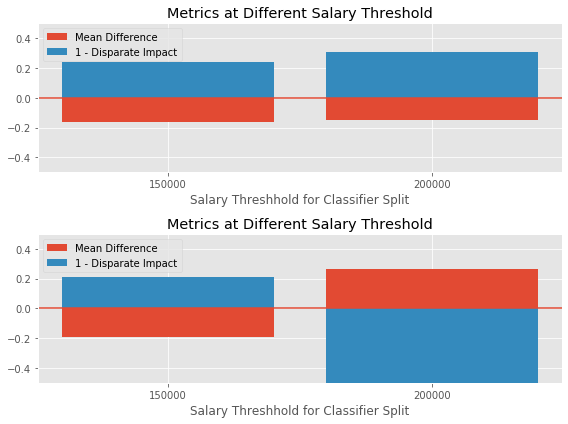

In [107]:
plot_mean_diff_and_di(val_mean, val_di, adb_mean, adb_di, 'images/adb_metrics.png')

## Inprocessing PrejudiceRemover

In [108]:
pr = PrejudiceRemover(sensitive_attr='sex', class_attr='salary')
pr.fit(train[0])
pr2 = PrejudiceRemover(sensitive_attr='sex', class_attr='salary')
pr2.fit(train[1])

In [109]:
pr_preds_1 = pr.predict(val[0])
pr_preds_2 = pr2.predict(val[1])
pr_preds = [pr_preds_1, pr_preds_2]


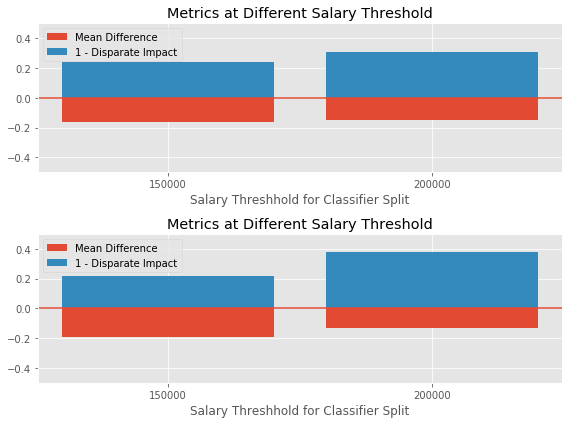

In [110]:
pr_mean, pr_di = get_dataset_metrics_list(pr_preds)
plot_mean_diff_and_di(val_mean, val_di, pr_mean, pr_di, 'images/pr_metrics.png')

### PostProcessing with Calibrated Odd Postprocessing

#### With Random Forest Predictions

In [111]:
cpp_rf = CalibratedEqOddsPostprocessing(privileged_groups = privileged_groups,
                                     unprivileged_groups = unprivileged_groups,
                                     cost_constraint='weighted')
cpp2_rf= CalibratedEqOddsPostprocessing(privileged_groups = privileged_groups,
                                     unprivileged_groups = unprivileged_groups,
                                     cost_constraint='weighted')

cpp_rf.fit(val[0], pred_list[0])
cpp2_rf.fit(val[1], pred_list[1])

In [112]:
cpp_preds_rf_1 = cpp_rf.predict(pred_list[0])
cpp_preds_rf_2 = cpp2_rf.predict(pred_list[1])
cpp_rf_preds = [cpp_preds_rf_1, cpp_preds_rf_2]


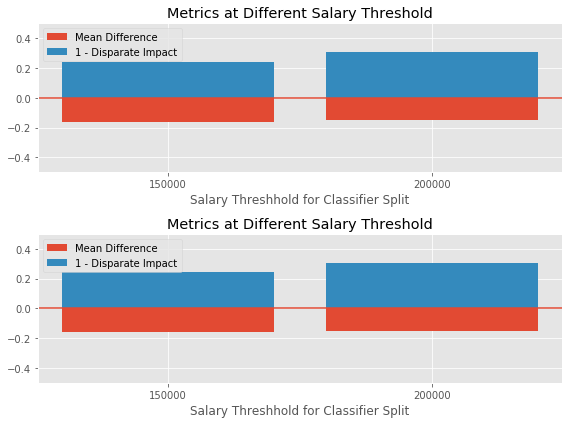

In [113]:
cpp_rf_mean, cpp_rf_di = get_dataset_metrics_list(cpp_rf_preds)
plot_mean_diff_and_di(val_mean, val_di, cpp_rf_mean, cpp_rf_di, 'images/cpp_rf_metrics.png')

#### With Adversarial Debiasing Predictions 


In [114]:
cpp_adb = CalibratedEqOddsPostprocessing(privileged_groups = privileged_groups,
                                     unprivileged_groups = unprivileged_groups,
                                     cost_constraint='weighted')
cpp2_adb = CalibratedEqOddsPostprocessing(privileged_groups = privileged_groups,
                                     unprivileged_groups = unprivileged_groups,
                                     cost_constraint='weighted')

cpp_adb.fit(val[0],adb_preds[0])
cpp2_adb.fit(val[1], adb_preds[1])

In [115]:
cpp_preds_adb_1 = cpp_adb.predict(adb_preds[0])
cpp_preds_adb_2 = cpp2_adb.predict(adb_preds[1])
cpp_adb_preds = [cpp_preds_adb_1, cpp_preds_adb_2]

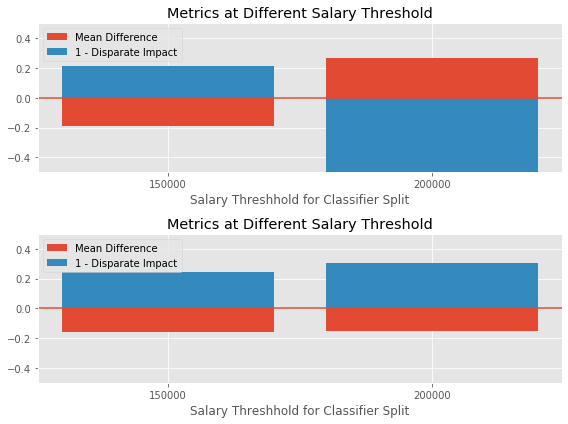

In [116]:
cpp_adb_mean, cpp_adb_di = get_dataset_metrics_list(cpp_adb_preds)
plot_mean_diff_and_di(adb_mean, adb_di, cpp_adb_mean, cpp_adb_di, 'images/cpp_adb_metrics.png')

### Reviewing the Overall Metrics to Choose the Best Model

In [117]:
rf_metrics = get_classifier_metrics(val, pred_list)
rf_rw_metrics = get_classifier_metrics(val, rw_pred_list)
adb_metrics = get_classifier_metrics(val, adb_preds)
pr_metrics = get_classifier_metrics(val, pr_preds)
cpp_rf_metrics = get_classifier_metrics(val, cpp_rf_preds)
cpp_adb_metrics = get_classifier_metrics(val, cpp_adb_preds)


In [118]:
results_150 = {'Random Forest': np.array(rf_metrics)[:,0],
                'Reweighted Random Forest':np.array(rf_rw_metrics)[:,0],
                'Adversarial Debiasing':np.array(adb_metrics)[:,0], 
                'Prejudice Remover':np.array(pr_metrics)[:,0] ,
                'Post-Proc Random Forest':np.array(cpp_rf_metrics)[:,0], 
               'Post-Proc Adversarial Debiasing':np.array(cpp_adb_metrics)[:,0]}

results_200 = {'Random Forest': np.array(rf_metrics)[:,1],
                'Reweighted Random Forest':np.array(rf_rw_metrics)[:,1],
                'Adversarial Debiasing':np.array(adb_metrics)[:,1], 
                'Prejudice Remover':np.array(pr_metrics)[:,1] ,
                'Post-Proc Random Forest':np.array(cpp_rf_metrics)[:,1], 
               'Post-Proc Adversarial Debiasing':np.array(cpp_adb_metrics)[:,1]}

In [119]:
#np.array([pred_mean[0], rw_pred_mean[0], adb_mean[0], pr_mean[0], cpp_rf_mean[0], cpp_adb_mean[0])
results_150_df = pd.DataFrame.from_dict(results_150, orient='index', columns=['Accuracy', 'Balanced Accuracy', 'Average Odds Difference', 'Equal Opporunity Difference', 'Precision Difference']) 
results_200_df = pd.DataFrame.from_dict(results_200, orient='index', columns=['Accuracy', 'Balanced Accuracy', 'Average Odds Difference', 'Equal Opporunity Difference', 'Precision Difference'])

results_150_df.insert(loc=0, column = 'Mean Difference', value = [pred_mean[0], rw_pred_mean[0], adb_mean[0], pr_mean[0], cpp_rf_mean[0], cpp_adb_mean[0]])
results_200_df.insert(loc=0, column = 'Mean Difference', value = [pred_mean[1], rw_pred_mean[1], adb_mean[1], pr_mean[1], cpp_rf_mean[1], cpp_adb_mean[1]])

results_150_df.insert(loc=1, column = '1-Disparate Impact', value = [pred_di[0], rw_pred_di[0], adb_di[0], pr_di[0], cpp_rf_di[0], cpp_adb_di[0]])
results_200_df.insert(loc=1, column = '1-Disparate Impact', value = [pred_di[1], rw_pred_di[1], adb_di[1], pr_di[1], cpp_rf_di[1], cpp_adb_di[1]])




In [120]:
display(Markdown("#### Predicting Salary > 150,000 Model"))
print('Original Training Mean Difference {:2.3f} and 1-Disparate Impact {:2.3f} \n'.format(train_mean[0], train_di[0]))
print('Original Validation Mean Difference {:2.3f} and 1-Disparate Impact {:2.3f} \n'.format(val_mean[0], val_di[0]))
results_150_df

#### Predicting Salary > 150,000 Model

Original Training Mean Difference -0.159 and 1-Disparate Impact 0.239 

Original Validation Mean Difference -0.161 and 1-Disparate Impact 0.243 



,Mean Difference,1-Disparate Impact,Accuracy,Balanced Accuracy,Average Odds Difference,Equal Opporunity Difference,Precision Difference
Random Forest,-0.194107,0.216431,0.774,0.716,-0.147,-0.000,-0.026
Reweighted Random Forest,-0.194107,0.216431,0.774,0.716,-0.147,-0.000,-0.026
Adversarial Debiasing,-0.190178,0.212983,0.773,0.715,-0.143,0.004,-0.026
Prejudice Remover,-0.194843,0.217490,0.776,0.717,-0.147,-0.000,-0.025
Post-Proc Random Forest,-0.161347,0.243335,1.000,1.000,0.000,0.000,0.000
Post-Proc Adversarial Debiasing,-0.161347,0.243335,1.000,1.000,0.000,0.000,0.000


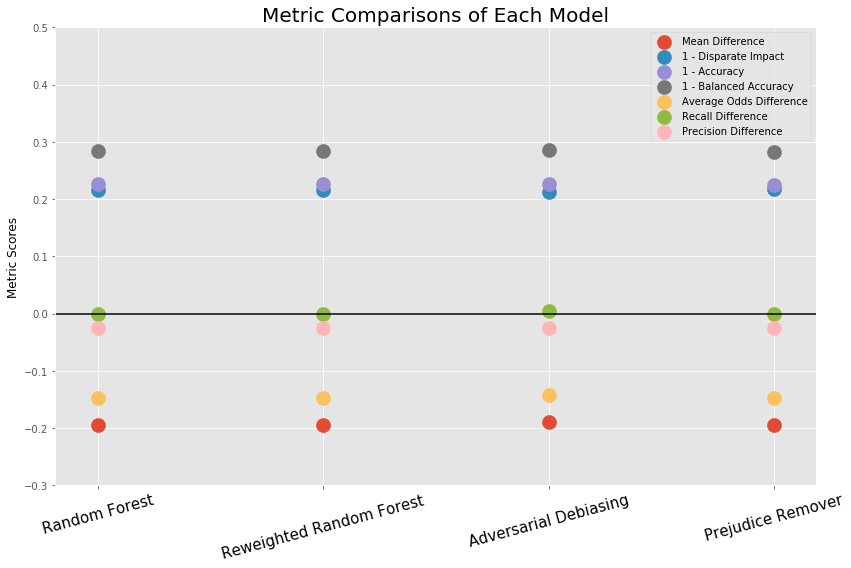

In [121]:
fig, ax = plt.subplots(figsize = (12,8))
x_axis = np.linspace(0,3,4)


ax.scatter(x_axis, results_150_df.iloc[0:4,0].values, label='Mean Difference', s=200 )
ax.scatter(x_axis, results_150_df.iloc[0:4,1].values, label='1 - Disparate Impact', s=200 )
ax.scatter(x_axis, 1 - results_150_df.iloc[0:4,2].values, label='1 - Accuracy', s=200 )
ax.scatter(x_axis, 1- results_150_df.iloc[0:4,3].values, label='1 - Balanced Accuracy', s=200 )
ax.scatter(x_axis, results_150_df.iloc[0:4,4].values, label='Average Odds Difference', s=200 )
ax.scatter(x_axis, results_150_df.iloc[0:4,5].values, label='Recall Difference', s=200 )
ax.scatter(x_axis, results_150_df.iloc[0:4,6].values, label='Precision Difference', s=200 )

ax.axhline(0, color='black')
ax.set_xticks(x_axis)
ax.set_xticklabels(results_150_df.index, rotation=15, color='black', size=15 )
# ax.set_title('Dataset Metrics at Different Salary Threshold')
# ax.set_xlabel('Salary Threshhold for Classifier Split')

ax.legend(loc='upper right')
ax.set_ylim(-.3, .5)
ax.set_ylabel('Metric Scores', color = 'black')
ax.set_title('Metric Comparisons of Each Model',size=20)
plt.tight_layout()
plt.savefig('images/model_150_metrics_v3')

In [122]:
display(Markdown("#### Predicting Salary > 200,000 Models"))
print('Original Training Mean Difference {:2.3f} and 1-Disparate Impact {:2.3f} \n'.format(train_mean[1], train_di[1]))
print('Original Validation Mean Difference {:2.3f} and 1-Disparate Impact {:2.3f} \n'.format(val_mean[1], val_di[1]))
results_200_df

#### Predicting Salary > 200,000 Models

Original Training Mean Difference -0.112 and 1-Disparate Impact 0.241 

Original Validation Mean Difference -0.152 and 1-Disparate Impact 0.304 



,Mean Difference,1-Disparate Impact,Accuracy,Balanced Accuracy,Average Odds Difference,Equal Opporunity Difference,Precision Difference
Random Forest,-0.143250,0.412919,0.661,0.641,-0.111,-0.150,-0.125
Reweighted Random Forest,-0.128510,0.372467,0.661,0.641,-0.094,-0.125,-0.124
Adversarial Debiasing,0.264794,-0.748949,0.637,0.632,0.325,0.392,-0.194
Prejudice Remover,-0.130345,0.377785,0.661,0.642,-0.095,-0.125,-0.119
Post-Proc Random Forest,-0.151789,0.304444,1.000,1.000,0.000,0.000,0.000
Post-Proc Adversarial Debiasing,-0.151789,0.304444,1.000,1.000,0.000,0.000,0.000


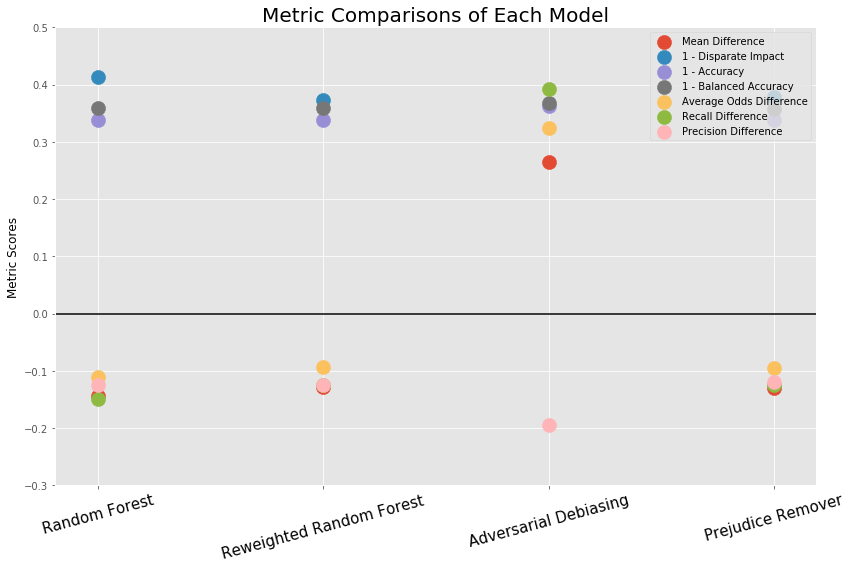

In [142]:
fig, ax = plt.subplots(figsize = (12,8))
x_axis = np.linspace(0,3,4)


ax.scatter(x_axis, results_200_df.iloc[0:4,0].values, label='Mean Difference', s=200 )
ax.scatter(x_axis, results_200_df.iloc[0:4,1].values, label='1 - Disparate Impact', s=200 )
ax.scatter(x_axis, 1 - results_200_df.iloc[0:4,2].values, label='1 - Accuracy', s=200 )
ax.scatter(x_axis, 1- results_200_df.iloc[0:4,3].values, label='1 - Balanced Accuracy', s=200 )
ax.scatter(x_axis, results_200_df.iloc[0:4,4].values, label='Average Odds Difference', s=200 )
ax.scatter(x_axis, results_200_df.iloc[0:4,5].values, label='Recall Difference', s=200 )
ax.scatter(x_axis, results_200_df.iloc[0:4,6].values, label='Precision Difference', s=200 )

ax.axhline(0, color='black')
ax.set_xticks(x_axis)
ax.set_xticklabels(results_200_df.index, rotation=15, color='black', size=15 )
# ax.set_title('Dataset Metrics at Different Salary Threshold')
# ax.set_xlabel('Salary Threshhold for Classifier Split')

ax.legend(loc='upper right')
ax.set_ylim(-.3, .5)
ax.set_ylabel('Metric Scores', color = 'black')
ax.set_title('Metric Comparisons of Each Model',size=20)
plt.tight_layout()
plt.savefig('images/model_200_metrics_v2')

In [124]:
#Baseline
priv, unpriv = get_confusion_matrix(val[0], val[0])

Confusion Matrix for Men {'TP': 675.0, 'FP': 0.0, 'TN': 343.0, 'FN': 0.0}
Confusion Matrix for Women {'TP': 292.0, 'FP': 0.0, 'TN': 290.0, 'FN': 0.0}


In [125]:
print('Confusion Matrix for Men')
confusion_matrix_to_df_from_dict(priv)


Confusion Matrix for Men


,Actual True,Actual False
Predicted True,675.0,0.0
Predicted False,0.0,343.0


In [126]:
print('Confusion Matrix for Women')
confusion_matrix_to_df_from_dict(unpriv)

Confusion Matrix for Women


,Actual True,Actual False
Predicted True,292.0,0.0
Predicted False,0.0,290.0


In [127]:
rf_priv, rf_unpriv = get_confusion_matrix(val[0], pred_list[0])

Confusion Matrix for Men {'TP': 673.0, 'FP': 240.0, 'TN': 103.0, 'FN': 2.0}
Confusion Matrix for Women {'TP': 291.0, 'FP': 118.0, 'TN': 172.0, 'FN': 1.0}


In [128]:
print('Confusion Matrix for Men')
confusion_matrix_to_df_from_dict(rf_priv)

Confusion Matrix for Men


,Actual True,Actual False
Predicted True,673.0,240.0
Predicted False,2.0,103.0


In [129]:
print('Confusion Matrix for Women')
confusion_matrix_to_df_from_dict(rf_unpriv)

Confusion Matrix for Women


,Actual True,Actual False
Predicted True,291.0,118.0
Predicted False,1.0,172.0


In [130]:
rf_rw_priv, rf_rw_unpriv = get_confusion_matrix(val[0], rw_pred_list[0])

Confusion Matrix for Men {'TP': 673.0, 'FP': 240.0, 'TN': 103.0, 'FN': 2.0}
Confusion Matrix for Women {'TP': 291.0, 'FP': 118.0, 'TN': 172.0, 'FN': 1.0}


In [131]:
print('Confusion Matrix for Men')
confusion_matrix_to_df_from_dict(rf_rw_priv)

Confusion Matrix for Men


,Actual True,Actual False
Predicted True,673.0,240.0
Predicted False,2.0,103.0


In [132]:
print('Confusion Matrix for Women')
confusion_matrix_to_df_from_dict(rf_rw_unpriv)

Confusion Matrix for Women


,Actual True,Actual False
Predicted True,291.0,118.0
Predicted False,1.0,172.0


In [133]:
adb_priv, adb_unpriv = get_confusion_matrix(val[0], adb_preds[0])

Confusion Matrix for Men {'TP': 670.0, 'FP': 239.0, 'TN': 104.0, 'FN': 5.0}
Confusion Matrix for Women {'TP': 291.0, 'FP': 118.0, 'TN': 172.0, 'FN': 1.0}


In [134]:
print('Confusion Matrix for Men')
confusion_matrix_to_df_from_dict(adb_priv)

Confusion Matrix for Men


,Actual True,Actual False
Predicted True,670.0,239.0
Predicted False,5.0,104.0


In [135]:
print('Confusion Matrix for Women')
confusion_matrix_to_df_from_dict(adb_unpriv)

Confusion Matrix for Women


,Actual True,Actual False
Predicted True,291.0,118.0
Predicted False,1.0,172.0


In [136]:
pr_priv, pr_unpriv = get_confusion_matrix(val[0], pr_preds[0])

Confusion Matrix for Men {'TP': 673.0, 'FP': 239.0, 'TN': 104.0, 'FN': 2.0}
Confusion Matrix for Women {'TP': 291.0, 'FP': 117.0, 'TN': 173.0, 'FN': 1.0}


In [137]:
print('Confusion Matrix for Men')
confusion_matrix_to_df_from_dict(pr_priv)

Confusion Matrix for Men


,Actual True,Actual False
Predicted True,673.0,239.0
Predicted False,2.0,104.0


In [138]:
print('Confusion Matrix for Women')
confusion_matrix_to_df_from_dict(pr_unpriv)

Confusion Matrix for Women


,Actual True,Actual False
Predicted True,291.0,117.0
Predicted False,1.0,173.0


In [139]:
cpp_rf_priv, cpp_rf_unpriv = get_confusion_matrix(val[0], cpp_rf_preds[0])

Confusion Matrix for Men {'TP': 675.0, 'FP': 0.0, 'TN': 343.0, 'FN': 0.0}
Confusion Matrix for Women {'TP': 292.0, 'FP': 0.0, 'TN': 290.0, 'FN': 0.0}


In [140]:
print('Confusion Matrix for Men')
confusion_matrix_to_df_from_dict(cpp_rf_priv)

Confusion Matrix for Men


,Actual True,Actual False
Predicted True,675.0,0.0
Predicted False,0.0,343.0


In [141]:
print('Confusion Matrix for Women')
confusion_matrix_to_df_from_dict(cpp_rf_unpriv)

Confusion Matrix for Women


,Actual True,Actual False
Predicted True,292.0,0.0
Predicted False,0.0,290.0


In [144]:
## Get Testing Predictions 
rw_test_preds = get_rw_predictions(RandomForestClassifier(n_estimators=500, max_depth=5), rw_train_datasets, test)
adb_test_preds = db_model.predict(test[0])
pr_test_preds = pr.predict(test[0])



In [169]:
type(pr_test_preds)

aif360.datasets.binary_label_dataset.BinaryLabelDataset

In [157]:
#Get Testing Metrics 

rf_rw_test_metrics = get_classifier_metrics(test, rw_test_preds)
adb_test_metrics = get_classifier_metrics([test[0]], [adb_test_preds])
pr_test_metrics = get_classifier_metrics([test[0]], [pr_test_preds])



In [166]:
results_test_150 = {'Reweighted Random Forest':np.array(rf_rw_test_metrics)[:,0],
                'Adversarial Debiasing':np.array(adb_test_metrics)[:,0], 
                'Prejudice Remover':np.array(pr_test_metrics)[:,0]}


In [187]:
rw_test_mean, rw_test_di = get_dataset_metrics_list(rw_test_preds)
adb_test_mean, adb_test_di = get_dataset_metrics_list([adb_test_preds])
pr_test_mean, pr_test_di = get_dataset_metrics_list([pr_test_preds])
test_mean, test_di = get_dataset_metrics_list(test)

In [179]:
results_test_150_df = pd.DataFrame.from_dict(results_test_150, orient='index', columns=['Accuracy', 'Balanced Accuracy', 'Average Odds Difference', 'Equal Opporunity Difference', 'Precision Difference']) 
results_test_150_df.insert(loc=0, column = 'Mean Difference', value = [rw_test_mean[0], adb_test_mean[0], pr_test_mean[0]])
results_test_150_df.insert(loc=1, column = '1-Disparate Impact', value = [rw_test_di[0], adb_test_di[0], pr_test_di[0]])


In [188]:
display(Markdown("#### Predicting Salary > 150,000 Models"))
print('Original Training Mean Difference {:2.3f} and 1-Disparate Impact {:2.3f} \n'.format(train_mean[0], train_di[0]))
print('Original Test Mean Difference {:2.3f} and 1-Disparate Impact {:2.3f} \n'.format(test_mean[0], test_di[0]))

results_test_150_df

#### Predicting Salary > 150,000 Models

Original Training Mean Difference -0.159 and 1-Disparate Impact 0.239 

Original Test Mean Difference -0.137 and 1-Disparate Impact 0.202 



,Mean Difference,1-Disparate Impact,Accuracy,Balanced Accuracy,Average Odds Difference,Equal Opporunity Difference,Precision Difference
Reweighted Random Forest,-0.175374,0.194059,0.782,0.707,-0.146,-0.004,-0.011
Adversarial Debiasing,0.257951,-0.756084,0.617,0.645,0.279,0.412,-0.079
Prejudice Remover,-0.175374,0.194059,0.782,0.707,-0.146,-0.004,-0.011


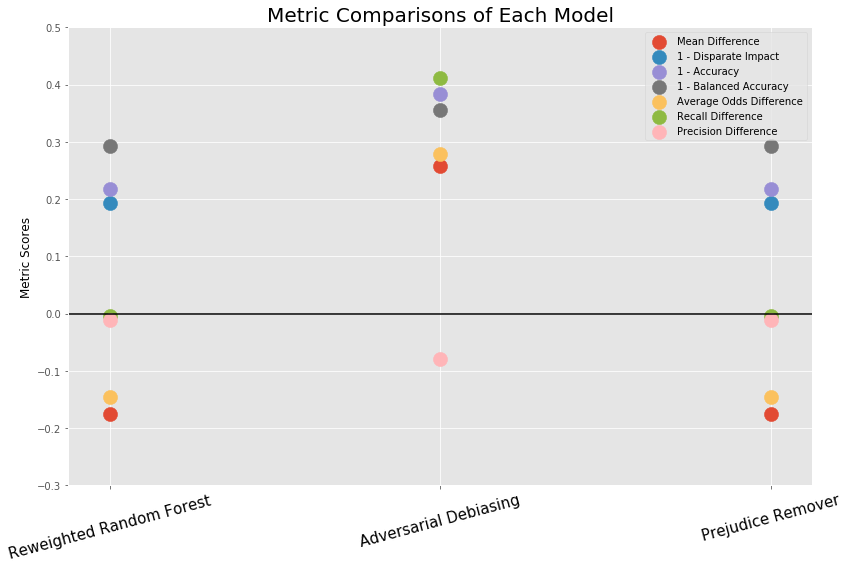

In [182]:
fig, ax = plt.subplots(figsize = (12,8))
x_axis = np.linspace(0,2,3)


ax.scatter(x_axis, results_test_150_df.iloc[:,0].values, label='Mean Difference', s=200 )
ax.scatter(x_axis, results_test_150_df.iloc[:,1].values, label='1 - Disparate Impact', s=200 )
ax.scatter(x_axis, 1 - results_test_150_df.iloc[:,2].values, label='1 - Accuracy', s=200 )
ax.scatter(x_axis, 1- results_test_150_df.iloc[:,3].values, label='1 - Balanced Accuracy', s=200 )
ax.scatter(x_axis, results_test_150_df.iloc[:,4].values, label='Average Odds Difference', s=200 )
ax.scatter(x_axis, results_test_150_df.iloc[:,5].values, label='Recall Difference', s=200 )
ax.scatter(x_axis, results_test_150_df.iloc[:,6].values, label='Precision Difference', s=200 )

ax.axhline(0, color='black')
ax.set_xticks(x_axis)
ax.set_xticklabels(results_test_150_df.index, rotation=15, color='black', size=15 )
# ax.set_title('Dataset Metrics at Different Salary Threshold')
# ax.set_xlabel('Salary Threshhold for Classifier Split')

ax.legend(loc='upper right')
ax.set_ylim(-.3, .5)
ax.set_ylabel('Metric Scores', color = 'black')
ax.set_title('Metric Comparisons of Each Model',size=20)
plt.tight_layout()
plt.savefig('images/model_150_metrics_test')